<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>1.5 Structural Causal Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: f7b1abb57541776dc786174deb102ca4ab864df6

watermark  : 2.5.0
numpy      : 2.2.4
pandas     : 2.2.3
matplotlib : 3.10.0
statsmodels: 0.14.4



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Modeling Causal Assumptions

We can load the structure of this model directly from disk:

In [4]:
G = CausalModel('dags/Primer.Fig.1.9.dot')

And plot it quickly

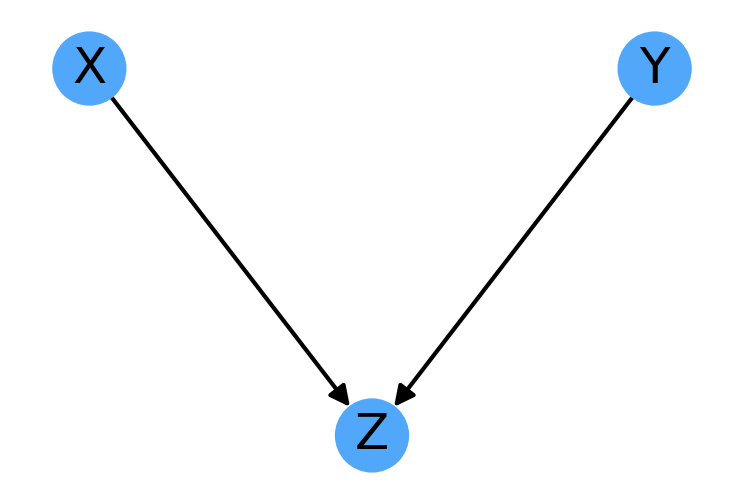

In [5]:
fig, ax = plt.subplots(1, figsize=(3, 2.2))
G.plot(ax=ax, legend=False)

We generate our fake data

In [6]:
x = np.linspace(20, 30)
y = np.linspace(100, 300, 50)
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

Z = 2*X+3*Y

model = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

And inspect it:

In [7]:
model

,X,Y,Z
0,20.000000,100.0,340.000000
1,20.204082,100.0,340.408163
2,20.408163,100.0,340.816327
3,20.612245,100.0,341.224490
4,20.816327,100.0,341.632653
...,...,...,...
2495,29.183673,300.0,958.367347
2496,29.387755,300.0,958.775510
2497,29.591837,300.0,959.183673
2498,29.795918,300.0,959.591837


And to go the other way, we simply perform an OLS Linear Regression fit to estimate the dependency of Z as a function of X and Y

In [8]:
ols = smf.ols('Z ~ X + Y', model).fit()

From where we easily extract the coefficients of our model for $f_Z$

In [9]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.426e+32
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:24:56   Log-Likelihood:                 68820.
No. Observations:                2500   AIC:                        -1.376e+05
Df Residuals:                    2497   BIC:                        -1.376e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.405e-13   4.94e-14     -8.924      0.000   -5.37e-13   -3.44e-13
X              2.0000   1.82e-15    1.1e+15      0.000       2.000       2.000
Y              3.0000   9.11e-17   3.29e+16      0.000       3.000       3.000
==============================================================================
Omnibus:                     1535.585   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.333
Skew:                          -0.052   Prob(JB):                     1.24e-31
Kurtosis:                       1.836   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let us now build the model for SCM 1.5.3

In [10]:
G2 = CausalModel()
G2.add_causation(r'$U_X$', 'X')
G2.add_causation(r'$U_Y$', 'Y')
G2.add_causation(r'$U_Z$', 'Z')
G2.add_causation('X', 'Y')
G2.add_causation('Y', 'Z')
G2.pos = {r'$U_X$': (-1, 1), r'$U_Y$':(0,1), r'$U_Z$': (1,1), 'X': (-1, 0), 'Y':(0,0), 'Z':(1, 0)}

Visualize it

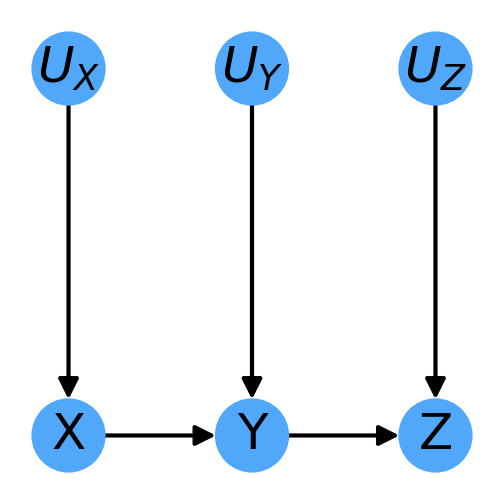

In [11]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G2.plot(ax=ax)

And save it as a dot file so that we can reuse it later on.

In [12]:
G2.save_model('dags/Primer.SCM.1.5.3.dot')

Since this is a stochastic model, we have to use random numbers. We'll assume that the exogenous variables are normally distributed and generate 100,000 values for each of them

In [13]:
N = 100_000
Ux = np.random.normal(size=N) 
Uy = np.random.normal(size=N)
Uz = np.random.normal(size=N)

And define the 3 functions that determine the values of X, Y and Z

In [14]:
fX = lambda ux: ux
fY = lambda x, uy: 1/3*x+uy
fZ = lambda y, uz: 1/16*y+uz

With these two ingredients at hand, we can easily build up the DataFrame that describes our model

In [15]:
X = fX(Ux)
Y = fY(X, Uy)
Z = fZ(Y, Uz)

model = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

And inspect it

In [16]:
model

,X,Y,Z
0,-0.453647,0.323354,0.256187
1,-0.467148,0.281140,1.145253
2,0.648764,-0.221812,1.601727
3,0.836560,-0.138470,0.157039
4,-0.766832,0.118769,-0.272225
...,...,...,...
99995,2.915592,2.937433,2.335802
99996,0.152174,-0.653557,0.086846
99997,-0.323138,-1.991928,2.280525
99998,0.310742,-0.441795,-0.725841


If we observe that Y=3, then the expected (mean) value of Z is:

In [17]:
Z_Y3 = np.mean(fZ(3, Uz))
print(Z_Y3)

0.18586458576187698


Which is close to the analytically expected value of 3/16=0.1875

Another way of calculating this value would be through a direct fit using the numerical values in our DataFrame

In [18]:
ols = smf.ols('Z ~ Y', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     457.6
Date:                Sat, 26 Apr 2025   Prob (F-statistic):          2.64e-101
Time:                        13:24:57   Log-Likelihood:            -1.4187e+05
No. Observations:              100000   AIC:                         2.837e+05
Df Residuals:                   99998   BIC:                         2.838e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0016      0.003     -0.516      0.606      -0.008       0.005
Y              0.0641      0.003     21.393      0.000       0.058       0.070
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.602
Skew:                          -0.006   Prob(JB):                        0.740
Kurtosis:                       2.999   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
ols.predict({'Y': 3})

0    0.190555
dtype: float64

With the added advantage that this approach takes into account also the values of the exogenous (error) variables.

If, on the other hand, we observe that $X=3$ then our calculation requires 2 steps, as this information must *flow* from X to Y and finally to Z

In [20]:
Y_X3 = fY(3, Uy)
Z_X3 = np.mean(fZ(Y_X3, Uz))
print(Z_X3)

0.06074898028192925


Which again is close to the expected analytical value of 1/16=0.0625

Or a simple fit

In [21]:
ols = smf.ols('Z ~ X', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     47.25
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           6.28e-12
Time:                        13:24:57   Log-Likelihood:            -1.4207e+05
No. Observations:              100000   AIC:                         2.842e+05
Df Residuals:                   99998   BIC:                         2.842e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.003     -0.552      0.581      -0.008       0.004
X              0.0217      0.003      6.874      0.000       0.016       0.028
==============================================================================
Omnibus:                        0.439   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.440
Skew:                          -0.005   Prob(JB):                        0.803
Kurtosis:                       2.999   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
ols.predict({'X': 3})

0    0.063301
dtype: float64

We can also run the computation in the opposite direction (contrary to the direction of causality). If we want to know the expected value of $X$ given that $Y=2$. In this case we must fit a linear regression model to obtain a the dependency of X as a function of Y

In [23]:
ols = smf.ols('X ~ Y', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                 1.146e+04
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:24:57   Log-Likelihood:            -1.3690e+05
No. Observations:              100000   AIC:                         2.738e+05
Df Residuals:                   99998   BIC:                         2.738e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0031      0.003     -1.041      0.298      -0.009       0.003
Y              0.3051      0.003    107.062      0.000       0.299       0.311
==============================================================================
Omnibus:                        0.166   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.920   Jarque-Bera (JB):                0.174
Skew:                           0.001   Prob(JB):                        0.917
Kurtosis:                       2.994   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
ols.predict({'Y': 2})

0    0.606993
dtype: float64

We can also use a similar approach to estimate the values of variables in the middle of a causal chain when we know the values before and after. For example, if we want to estimate the value of Y given that we observe specific values for X and Z, all we have to do is fit a linear model for Y as a function of X and Z

In [25]:
ols = smf.ols('Y ~ X + Z', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5960.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:24:57   Log-Likelihood:            -1.4169e+05
No. Observations:              100000   AIC:                         2.834e+05
Df Residuals:                   99997   BIC:                         2.834e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.003     -0.546      0.585      -0.008       0.004
X              0.3357      0.003    106.815      0.000       0.330       0.342
Z              0.0638      0.003     20.253      0.000       0.058       0.070
==============================================================================
Omnibus:                        3.765   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.770
Skew:                          -0.015   Prob(JB):                        0.152
Kurtosis:                       2.997   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And now that we have a description of Y as a function X and Z, we can simply plugin the numbers

In [26]:
ols.predict({'X':1, 'Z':3})

0    0.525399
dtype: float64

### Blocking variables.

An interesting point to make clear (and that we will delve into more deeply in Chapt 2) is that to determine the value of a given variable, we only need the know the values of it's parents. 

Let's say we observe that Y=3 and are interested in finding out the value of Z. We can simply do:

In [27]:
ols = smf.ols('Z ~ Y', model).fit()
ols.predict({'Y': 3})

0    0.190555
dtype: float64

On the other hand, let's say that we also observe that X=1. In this case, we would do:

In [28]:
ols = smf.ols('Z ~ Y + X', model).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     228.8
Date:                Sat, 26 Apr 2025   Prob (F-statistic):          7.09e-100
Time:                        13:24:58   Log-Likelihood:            -1.4187e+05
No. Observations:              100000   AIC:                         2.837e+05
Df Residuals:                   99997   BIC:                         2.838e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0016      0.003     -0.516      0.606      -0.008       0.005
Y              0.0640      0.003     20.253      0.000       0.058       0.070
X           9.768e-05      0.003      0.029      0.977      -0.006       0.007
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.602
Skew:                          -0.006   Prob(JB):                        0.740
Kurtosis:                       2.999   Cond. No.                         1.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
ols.predict({'Y': 3, 'X':1})

0    0.190564
dtype: float64

which returns the same result (up to numerical precision). While counterintuitive, this result is simple to understand. In our causal model, the value of Z is determined only by the value of Y. Once Y is determined, the factors that might have led to its value (a statistical fluctuation in Uy, or the value of X) are irrelevant. All that Z "sees" is the current value of Y and Y *shields* Z from everything that happened before in its causal chain

In this simple observation lies much of the power of this approach!

## Product Decomposition

In [30]:
G = CausalModel('dags/Primer.Fig.1.10.dot')

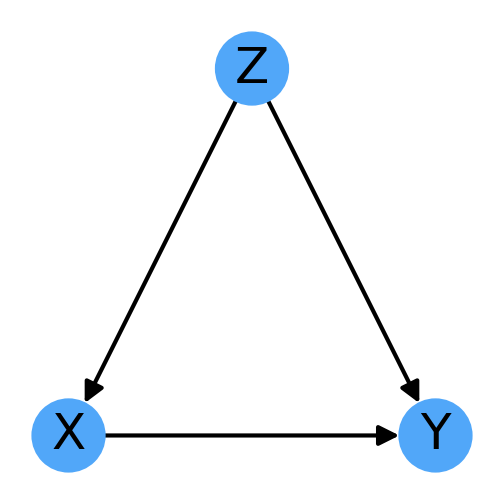

In [31]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [32]:
PZ = pd.DataFrame({'Z': [0, 1], 'P(Z)': ['1-r', 'r']})

In [33]:
PZ

,Z,P(Z)
0,0,1-r
1,1,r


In [34]:
MedicationProb = pd.DataFrame({
    'X': [1, 1, 0, 0],
    'Z': [0, 1, 0, 1],
    ' P(X | Z)': [r'$q_{0}$', r'$q_{1}$', r'$1-q_0$', r'$1-q_{1}$']
})

In [35]:
MedicationProb

,X,Z,P(X | Z)
0,1,0,$q_{0}$
1,1,1,$q_{1}$
2,0,0,$1-q_0$
3,0,1,$1-q_{1}$


In [36]:
DeathProb = pd.DataFrame({
    'Y':[1, 1, 1, 1, 0, 0, 0, 0],
    'X':[1, 0, 0, 1, 1, 0, 0, 1],
    'Z':[0, 0, 1, 1, 0, 0, 1, 1],
    'P(Y | X,Z)':[r'$p_{10}$', r'$p_{00}$', r'$p_{01}$', r'$p_{11}$', r'$1-p_{10}$', r'$1-p_{00}$', r'$1-p_{01}$', r'$1-p_{11}$']})

In [37]:
DeathProb

,Y,X,Z,"P(Y | X,Z)"
0,1,1,0,$p_{10}$
1,1,0,0,$p_{00}$
2,1,0,1,$p_{01}$
3,1,1,1,$p_{11}$
4,0,1,0,$1-p_{10}$
5,0,0,0,$1-p_{00}$
6,0,0,1,$1-p_{01}$
7,0,1,1,$1-p_{11}$


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>